In [2]:
import qiskit
import matplotlib.pyplot as plt
import numpy as np
import scipy
import networkx as nx
import time

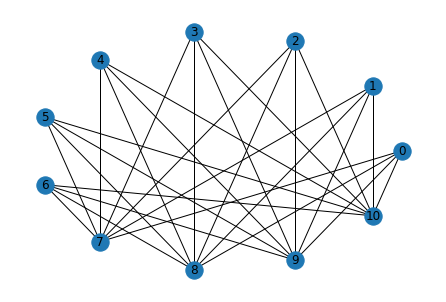

In [5]:
visible_states = [0, 1, 2, 3, 4, 5, 6]
hidden_states = [7, 8, 9, 10]
G = nx.Graph()
G.add_nodes_from(visible_states)
G.add_nodes_from(hidden_states)
G.add_edges_from([(i, j) for i in visible_states for j in hidden_states])
nx.draw_circular(G, with_labels=True)

In [6]:
num_qubits = len(visible_states) + len(hidden_states)

transverse_params = np.random.normal(loc=2, scale=0, size=num_qubits).astype(np.float32)
single_params = np.random.normal(scale=.5, size=num_qubits).astype(np.float32)
double_params =  {tuple(sorted(edge)): np.random.normal(scale=.01) for edge in G.edges}


H = np.zeros((2 ** num_qubits, 2 ** num_qubits))

pauli_z = np.array([[1, 0], [0, -1]])
pauli_x = np.array([[0, 1], [1, 0]])
identity = np.array([[1, 0], [0, 1]])

for i, b in enumerate(single_params):
    m = b
    for j in range(num_qubits):
        if j == i:
            m = np.kron(m, pauli_z)
        else:
            m = np.kron(m, identity)
    H = np.subtract(H, m)

for i, (a, b) in enumerate(G.edges()):
    m = double_params[(a, b)]
    for j in range(num_qubits):
        if j == a or j == b:
            m = np.kron(m, pauli_z)
        else:
            m = np.kron(m, identity)
    H = np.subtract(H, m)

for i in range(num_qubits):
    m = transverse_params[i]
    for j in range(num_qubits):
        if j == i:
            m = np.kron(m, pauli_x)
        else:
            m = np.kron(m, identity)
    H = np.subtract(H, m)

In [12]:
from active_coresets.maxcut_vqt import optimize_vqt
from active_coresets.ansatz import ZZansatz

In [7]:
beta = 1

In [ ]:
start_time = time.time()
ansatz = ZZansatz(G)
thermal_state = optimize_vqt(H, beta, ansatz)
total_vqt_time = time.time() - start_time

In [8]:
from qiskit.opflow.primitive_ops import PauliSumOp

In [9]:
start_time = time.time()
H = -1 * beta * H
exp_H = scipy.linalg.expm(H)
partition_function = np.trace(exp_H)
exact_thermal_state = qiskit.quantum_info.DensityMatrix(exp_H / partition_function)

expectations = np.zeros(num_qubits)

for i in range(num_qubits):
    pauli_str = 'I' * (i) + 'Z' + 'I' * (num_qubits - i - 1)
    expectations[i] = exact_thermal_state.expectation_value(PauliSumOp.from_list([(pauli_str, 1)])).real

for (i, j) in G.edges():
    pauli_str = 'I' * (i) + 'Z' + 'I' * (j - i - 1) + 'Z' + 'I' * (num_qubits - j - 1)
    expectation = exact_thermal_state.expectation_value(PauliSumOp.from_list([(pauli_str, 1)])).real
    print(f'Edge: {i} {j} | Expectation: {expectation}')

print(f'Exact expectations: {expectations}')

total_exact_time = time.time() - start_time

Edge: 0 7 | Expectation: 0.09984889889874118
Edge: 0 8 | Expectation: 0.014127775183160272
Edge: 0 9 | Expectation: -0.029285641743681378
Edge: 0 10 | Expectation: 0.018179668047254335
Edge: 1 7 | Expectation: 0.07338867360671522
Edge: 1 8 | Expectation: 0.008471333848935933
Edge: 1 9 | Expectation: -0.02286239278456272
Edge: 1 10 | Expectation: 0.01205837717010307
Edge: 2 7 | Expectation: -0.017475843088513764
Edge: 2 8 | Expectation: -0.005952261709098993
Edge: 2 9 | Expectation: 0.0017693148257024193
Edge: 2 10 | Expectation: -0.0017190068605820107
Edge: 3 7 | Expectation: 0.09415568819839429
Edge: 3 8 | Expectation: 0.015930561751444156
Edge: 3 9 | Expectation: -0.026889020780265463
Edge: 3 10 | Expectation: 0.011465542737863873
Edge: 4 7 | Expectation: -0.07650832769337684
Edge: 4 8 | Expectation: -0.01305171690884658
Edge: 4 9 | Expectation: 0.024519967726048367
Edge: 4 10 | Expectation: -0.01147861873687886
Edge: 5 7 | Expectation: 0.012665681675952885
Edge: 5 8 | Expectation: 0

In [18]:
print(f'Z: {z_exp}, ZZ: {zz_exp}')

Z: [ 0.09765625  0.11523438 -0.03710938  0.09765625 -0.08789062 -0.00195312
  0.          0.07226562  0.04296875 -0.015625    0.00585938], ZZ: [[ 0.09179688 -0.015625   -0.015625   -0.03710938]
 [ 0.00390625 -0.00976562  0.01757812 -0.01171875]
 [ 0.05078125  0.00976562 -0.00976562 -0.00390625]
 [ 0.02148438  0.04296875  0.03125    -0.02929688]
 [-0.05859375 -0.03710938 -0.00976562 -0.02734375]
 [-0.01953125 -0.01367188 -0.01367188  0.02734375]
 [ 0.08007812  0.0078125  -0.03515625  0.01367188]]


In [10]:
from active_coresets.qmc_tim_qbm import QMC_TIM_QBM

2022-03-07 09:25:11.111658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 09:25:11.111695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
weights = np.zeros((len(visible_states), len(hidden_states))).astype(np.float32)
for (a, b), weight in double_params.items():
    weights[a, b - len(visible_states)] = weight
params = {'gammas': transverse_params,
                'biases': single_params,
                'weights': weights}

betas = np.linspace(0, 1, 10).astype(np.float32)

qmc = QMC_TIM_QBM(visible_states, hidden_states, initial_params=params, num_replicas=512, num_its=10, betas=betas)
z_exp, zz_exp = qmc.negative_phase()

In [24]:
data = (-2 * np.random.randint(0, 2, size=(10, 3)) + np.ones((10, 3))).astype(np.float32)

In [31]:
pos_z_vis = np.mean(data, axis=0)

In [43]:
pos_z_hidden = 0
for d in data:
    b_eff = single_params[-len(hidden_states):] + np.einsum('ij,i->j', weights, d)
    D = np.sqrt(transverse_params[-len(hidden_states):]**2 + b_eff**2)
    pos_z_hidden += np.tanh(D) * b_eff / D
pos_z_hidden /= len(data)

In [44]:
pos_z_hidden

array([-0.04464434, -0.28615394], dtype=float32)

In [25]:
pos_z, pos_zz = qmc.positive_phase(data)

In [12]:
print(f'pos_z: {pos_z}, pos_zz: {pos_zz}')

NameError: name 'pos_z' is not defined

In [39]:
import importlib
import active_coresets.population_annealing
importlib.reload(active_coresets.population_annealing)

from active_coresets.population_annealing import population_annealing

In [44]:
z_expectations, zz_expectations, history = population_annealing(transverse_params, single_params, double_params, 10, 512, 0, 5, 0.2, 1)
print(f'Z expectations: {z_expectations}, ZZ expectations: {zz_expectations}')

Z expectations: [ 0.04726562 -0.06445312  0.06914062  0.028125   -0.046875  ], ZZ expectations: {(0, 3): 0.0013293457031249957, (0, 4): -0.0022155761718749903, (1, 3): -0.0018127441406249943, (1, 4): 0.003021240234374987, (2, 3): 0.001944580078124996, (2, 4): -0.0032409667968749897}


In [54]:
print(history[4][0])
print(np.mean(history[4], axis=0)[0])
print(np.mean(history[4], axis=(0, 1)))

[[ 1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1.]]
[-0.8671875  -0.9296875  -0.9609375  -0.90625    -0.91015625]
[0.0078125  0.00546875 0.00390625 0.00390625 0.00820313]


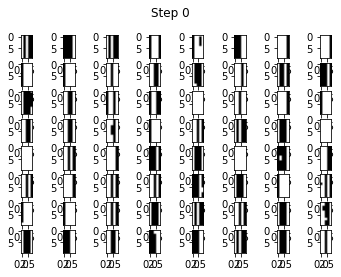

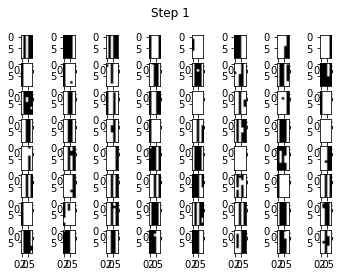

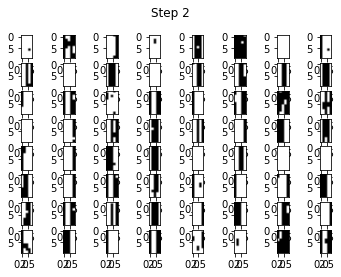

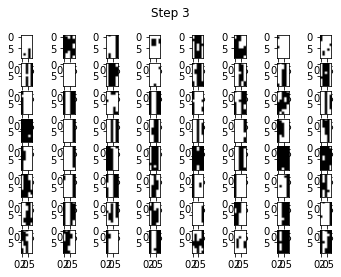

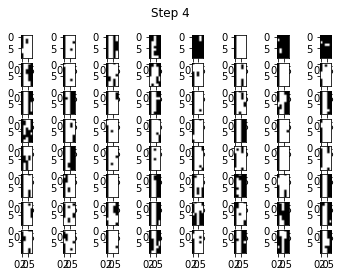

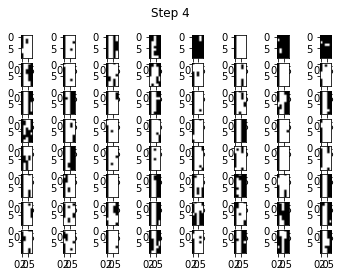

In [106]:
from celluloid import Camera
from IPython.display import display

fig, axs = plt.subplots(8, 8)
camera = Camera(fig)

num_steps = history.shape[0]
num_copies = history.shape[1]
num_units = history.shape[2]

for i in range(num_steps):
    for j in range(num_copies):
        row = j // 8
        axs[row, j - row * 8].imshow(history[i, j], cmap='binary')
        fig.suptitle(f'Step {i}')
    display(fig)
    camera.snap()

anim = camera.animate()
anim.save('animation.gif', writer='imagemagick', fps=1)
